In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loading train_transaction data
train_transaction = pd.read_csv('train_transaction.csv')
print(train_transaction.shape)
train_transaction = reduce_mem_usage(train_transaction)
train_transaction.head()

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

# C1-C14 

In [5]:
st = train_transaction.columns.get_loc('C1')
end = train_transaction.columns.get_loc('C14')

cdf = train_transaction.iloc[:, st:end+1]
cdf['isFraud'] = train_transaction['isFraud']
cdf.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0


In [6]:
cdf.select_dtypes(exclude=['float64']).nunique(axis=0)

C1         1495
C2         1167
C3           27
C4         1223
C5          319
C6         1291
C7         1069
C8         1130
C9          205
C10        1122
C11        1343
C12        1066
C13        1464
C14        1108
isFraud       2
dtype: int64

In [7]:
corr = cdf.corr()
corr.style.background_gradient(cmap='coolwarm')

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
C1,1.000000,0.995089,-0.003467,0.967801,0.165865,0.982239,0.926256,0.967746,0.176002,0.958202,0.996516,0.927938,0.774605,0.951763,0.030570
C2,0.995089,1.000000,-0.003339,0.972133,0.126541,0.974845,0.938866,0.975862,0.133567,0.970623,0.993898,0.940257,0.751221,0.936148,0.037229
C3,-0.003467,-0.003339,1.000000,-0.001720,-0.008101,-0.004711,-0.001730,-0.001203,-0.010074,-0.001494,-0.003583,-0.001763,-0.007747,-0.005091,-0.006833
C4,0.967801,0.972133,-0.001720,1.000000,-0.012842,0.962319,0.895092,0.959995,-0.015970,0.952466,0.974547,0.894618,0.644549,0.907676,0.030382
C5,0.165865,0.126541,-0.008101,-0.012842,1.000000,0.232409,-0.009970,-0.011654,0.925786,-0.011846,0.168861,-0.009875,0.717509,0.378950,-0.030754
C6,0.982239,0.974845,-0.004711,0.962319,0.232409,1.000000,0.858583,0.921972,0.250695,0.914440,0.991104,0.858182,0.808530,0.984201,0.020909
C7,0.926256,0.938866,-0.001730,0.895092,-0.009970,0.858583,1.000000,0.982983,-0.012399,0.985061,0.915210,0.999489,0.632393,0.794701,0.028161
C8,0.967746,0.975862,-0.001203,0.959995,-0.011654,0.921972,0.982983,1.000000,-0.014492,0.996970,0.962722,0.983027,0.653244,0.860246,0.032138
C9,0.176002,0.133567,-0.010074,-0.015970,0.925786,0.250695,-0.012399,-0.014492,1.000000,-0.014731,0.182444,-0.012212,0.704056,0.397396,-0.031703
C10,0.958202,0.970623,-0.001494,0.952466,-0.011846,0.914440,0.985061,0.996970,-0.014731,1.000000,0.956056,0.983816,0.653941,0.853009,0.028396


In [8]:
x = cdf.iloc[:,:-1]
scalar = StandardScaler()
df_scaled = pd.DataFrame(scalar.fit_transform(x), columns=x.columns)
df_scaled

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,-0.098022,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053925,-0.208740,-0.054840,-0.087341,-0.047058,-0.243896,-0.147339
1,-0.098022,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053925,-0.268799,-0.054840,-0.097961,-0.047058,-0.243896,-0.147339
2,-0.098022,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053925,-0.208740,-0.054840,-0.097961,-0.047058,-0.243896,-0.147339
3,-0.090515,-0.066406,-0.037506,-0.059448,-0.216064,-0.070923,-0.046143,-0.053925,-0.208740,-0.054840,-0.097961,-0.047058,-0.058289,-0.147339
4,-0.098022,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.043457,-0.268799,-0.044373,-0.097961,-0.047058,-0.243896,-0.147339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,-0.090515,-0.092285,-0.037506,-0.059448,-0.177246,-0.126831,-0.046143,-0.053925,-0.148804,-0.054840,-0.097961,-0.047058,-0.228394,-0.127075
590536,-0.098022,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053925,-0.208740,-0.054840,-0.097961,-0.047058,-0.243896,-0.147339
590537,-0.098022,-0.092285,-0.037506,-0.059448,-0.177246,-0.112854,-0.046143,-0.053925,-0.208740,-0.054840,-0.097961,-0.047058,-0.243896,-0.147339
590538,-0.098022,-0.092285,-0.037506,-0.059448,-0.216064,-0.084900,-0.046143,-0.053925,-0.148804,-0.054840,-0.097961,-0.035492,-0.212891,-0.147339


In [9]:
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
df_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.331301,-0.334253,-0.041045,0.000193,0.015158,0.035873,-0.016195,0.000838,0.003475,0.001174,-0.000956,0.006864,-0.006260,0.003416
1,-0.338322,-0.370803,-0.041324,0.003586,-0.028805,0.029391,-0.010428,-0.003813,0.000675,-0.011294,0.008165,0.002820,-0.001088,0.001479
2,-0.334624,-0.334171,-0.041048,-0.001610,0.014594,0.034772,-0.016389,0.000879,0.001846,0.001050,-0.001189,-0.000396,-0.000914,-0.000176
3,-0.264719,-0.264600,-0.040294,-0.003460,-0.018921,-0.103911,0.055204,0.004531,0.036424,-0.014300,0.008031,-0.007811,0.010668,-0.001941
4,-0.331937,-0.373693,-0.041336,-0.000052,-0.029359,0.027831,-0.016008,-0.001967,-0.000783,-0.002951,0.012613,0.004565,0.003861,0.002144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,-0.320596,-0.265941,-0.040407,-0.012081,0.031116,0.044712,-0.023542,-0.003020,-0.018138,0.011501,-0.010326,-0.002679,-0.002917,-0.000721
590536,-0.334624,-0.334171,-0.041048,-0.001610,0.014594,0.034772,-0.016389,0.000879,0.001846,0.001050,-0.001189,-0.000396,-0.000914,-0.000176
590537,-0.332286,-0.310492,-0.040786,-0.008678,-0.009664,0.051122,-0.021857,0.002622,0.002786,0.002016,-0.001023,-0.000312,-0.001198,-0.000211
590538,-0.311132,-0.286534,-0.040654,-0.005774,0.053998,0.017585,-0.015992,0.003842,0.025109,0.002390,-0.004835,-0.005541,0.003313,-0.013318


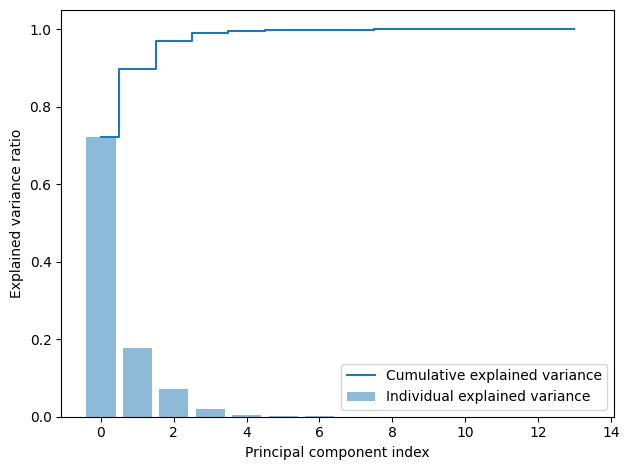

In [10]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
sum(pca.explained_variance_ratio_[:3])

0.9703526441264647

#  D1-D15

In [60]:
st = train_transaction.columns.get_loc('D1')
end = train_transaction.columns.get_loc('D15')

ddf = train_transaction.iloc[:, st:end+1]
ddf.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#missing values percentage
m_cnt = 0
drop_cols = []
for col, cnt in ddf.isnull().sum().items():
    if(cnt > 0):
        per = round(cnt*100/ddf.shape[0], 2)
        if(per > 20):
            drop_cols.append(str(col))
        print(str(col) + ': ' + str(per))
        m_cnt = m_cnt + 1

D1: 0.21
D2: 47.55
D3: 44.51
D4: 28.6
D5: 52.47
D6: 87.61
D7: 93.41
D8: 87.31
D9: 87.31
D10: 12.87
D11: 47.29
D12: 89.04
D13: 89.51
D14: 89.47
D15: 15.09


In [62]:
drop_cols

['D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14']

In [63]:
ddf = ddf.drop(drop_cols, axis = 1)
ddf.head()

,D1,D10,D15
0,14.0,13.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,315.0
3,112.0,84.0,111.0
4,0.0,NaN,NaN


In [64]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_ddf = pd.DataFrame(imp_median.fit_transform(ddf), columns=ddf.columns)
imp_ddf['isFraud'] = train_transaction['isFraud']
imp_ddf.head()

,D1,D10,D15,isFraud
0,14.0,13.0,0.0,0
1,0.0,0.0,0.0,0
2,0.0,0.0,315.0,0
3,112.0,84.0,111.0,0
4,0.0,15.0,52.0,0


In [65]:
imp_ddf.select_dtypes(exclude=['float64']).nunique(axis=0)

D1         641
D10        818
D15        859
isFraud      2
dtype: int64

In [66]:
corr = imp_ddf.corr()
corr.style.background_gradient(cmap='coolwarm')

,D1,D10,D15,isFraud
D1,1.000000,0.567605,0.636458,-0.067103
D10,0.567605,1.000000,0.708108,-0.070583
D15,0.636458,0.708108,1.000000,-0.073826
isFraud,-0.067103,-0.070583,-0.073826,1.000000


In [67]:
x = imp_ddf.iloc[:,:-1]
scalar = StandardScaler()
df_scaled = pd.DataFrame(scalar.fit_transform(x), columns=x.columns)
df_scaled

,D1,D10,D15
0,-0.508789,-0.556152,-0.769043
1,-0.597656,-0.630859,-0.769043
2,-0.597656,-0.630859,0.879883
3,0.113281,-0.148926,-0.187744
4,-0.597656,-0.544434,-0.496582
...,...,...,...
590535,-0.413330,-0.309326,-0.475586
590536,-0.597656,-0.630859,-0.769043
590537,-0.597656,-0.630859,-0.769043
590538,-0.457764,-0.504395,-0.653809


In [68]:
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
df_pca

,0,1,2
0,-1.063657,-0.058665,0.156530
1,-1.156210,-0.029594,0.092753
2,-0.170752,0.297694,-1.188150
3,-0.135322,-0.212074,0.083228
4,-0.943387,0.073247,-0.067978
...,...,...,...
590535,-0.692508,0.062337,0.095218
590536,-1.156210,-0.029594,0.092753
590537,-1.156210,-0.029594,0.092753
590538,-0.936521,-0.047484,0.108855


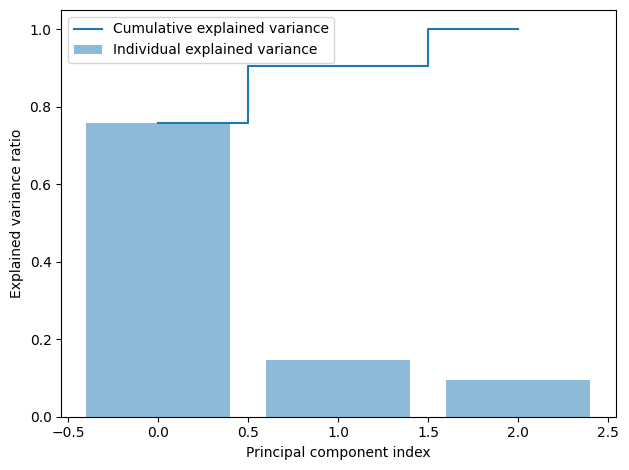

In [69]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [73]:
sum(pca.explained_variance_ratio_[:2])

0.9064447859618521

#  Vxxx

In [78]:
st = train_transaction.columns.get_loc('V1')
end = train_transaction.columns.get_loc('V339')

vdf = train_transaction.iloc[:, st:end+1]
vdf.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
#missing values percentage
m_cnt = 0
drop_cols = []
for col, cnt in vdf.isnull().sum().items():
    if(cnt > 0):
        per = round(cnt*100/ddf.shape[0], 2)
        if(per > 20):
            drop_cols.append(str(col))
        print(str(col) + ': ' + str(per))
        m_cnt = m_cnt + 1

V1: 47.29
V2: 47.29
V3: 47.29
V4: 47.29
V5: 47.29
V6: 47.29
V7: 47.29
V8: 47.29
V9: 47.29
V10: 47.29
V11: 47.29
V12: 12.88
V13: 12.88
V14: 12.88
V15: 12.88
V16: 12.88
V17: 12.88
V18: 12.88
V19: 12.88
V20: 12.88
V21: 12.88
V22: 12.88
V23: 12.88
V24: 12.88
V25: 12.88
V26: 12.88
V27: 12.88
V28: 12.88
V29: 12.88
V30: 12.88
V31: 12.88
V32: 12.88
V33: 12.88
V34: 12.88
V35: 28.61
V36: 28.61
V37: 28.61
V38: 28.61
V39: 28.61
V40: 28.61
V41: 28.61
V42: 28.61
V43: 28.61
V44: 28.61
V45: 28.61
V46: 28.61
V47: 28.61
V48: 28.61
V49: 28.61
V50: 28.61
V51: 28.61
V52: 28.61
V53: 13.06
V54: 13.06
V55: 13.06
V56: 13.06
V57: 13.06
V58: 13.06
V59: 13.06
V60: 13.06
V61: 13.06
V62: 13.06
V63: 13.06
V64: 13.06
V65: 13.06
V66: 13.06
V67: 13.06
V68: 13.06
V69: 13.06
V70: 13.06
V71: 13.06
V72: 13.06
V73: 13.06
V74: 13.06
V75: 15.1
V76: 15.1
V77: 15.1
V78: 15.1
V79: 15.1
V80: 15.1
V81: 15.1
V82: 15.1
V83: 15.1
V84: 15.1
V85: 15.1
V86: 15.1
V87: 15.1
V88: 15.1
V89: 15.1
V90: 15.1
V91: 15.1
V92: 15.1
V93: 15.1
V94: 

In [80]:
drop_cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V

In [81]:
vdf = vdf.drop(drop_cols, axis = 1)
vdf.head()

,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_vdf = pd.DataFrame(imp_median.fit_transform(vdf), columns=vdf.columns)
imp_vdf['isFraud'] = train_transaction['isFraud']
imp_vdf.head()

,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,isFraud
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [83]:
imp_vdf.select_dtypes(exclude=['float64']).nunique(axis=0)

V12            4
V13            7
V14            2
V15            8
V16           15
           ...  
V318       12309
V319        4799
V320        6439
V321        5560
isFraud        2
Length: 152, dtype: int64

In [84]:
corr = imp_vdf.corr()
corr.style.background_gradient(cmap='coolwarm')

In [85]:
x = imp_vdf.iloc[:,:-1]
scalar = StandardScaler()
df_scaled = pd.DataFrame(scalar.fit_transform(x), columns=x.columns)
df_scaled

,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,-0.227576,-0.222388,-0.249224,-0.229151,-0.048377,-0.032815,-0.058049,-0.055287,-0.088855,-0.074142
1,-1.235771,-1.264783,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,-0.227576,-0.222388,-0.249224,-0.229151,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
2,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,-0.227576,-0.222388,-0.249224,-0.229151,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
3,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,0.556707,-0.222388,-0.249224,-0.229151,-0.026351,0.290552,0.224769,-0.055287,-0.088855,-0.074142
4,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,-0.227576,-0.222388,-0.249224,-0.229151,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.773680,2.622068,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,-2.090159,-2.008641,-0.353679,...,-0.227576,0.277986,0.027165,0.181512,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
590536,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,-0.227576,-0.222388,-0.249224,-0.229151,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
590537,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,0.398048,0.306946,-0.353679,...,-0.227576,-0.222388,-0.249224,-0.229151,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
590538,0.768955,0.678642,0.020866,-0.340553,-0.333342,-0.340323,-0.336986,2.886256,2.622533,-0.353679,...,0.452136,3.091691,3.610846,2.490756,-0.048377,0.499095,-0.058049,-0.055287,-0.088855,-0.074142


In [86]:
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
df_pca

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,-1.296485,-1.797933,-0.353928,-0.137664,-1.726239,1.266060,-0.017270,-0.371474,0.019770,0.532317,...,0.000270,-0.000055,-0.000092,0.000026,-0.000070,6.280533e-06,-0.000006,1.396408e-05,0.000015,2.282660e-05
1,-0.959126,-0.622066,-0.616248,-0.795470,-0.650706,0.917615,-0.300256,0.843221,0.514344,-0.879307,...,0.000080,0.000133,-0.000164,0.000046,-0.000049,1.647332e-05,0.000006,7.668500e-07,0.000006,1.361788e-06
2,-1.284685,-1.629531,-0.264242,0.225042,-2.447929,0.453715,-0.166575,0.525181,0.239162,0.240688,...,0.000138,0.000064,-0.000046,0.000042,-0.000044,9.928788e-06,0.000003,-1.664326e-06,0.000006,6.607917e-07
3,1.663849,-2.983738,0.418322,2.374376,-0.318569,1.936915,-2.291489,2.113082,-0.838787,-0.728217,...,0.046836,-0.002968,-0.000289,-0.000414,-0.000205,-2.227778e-04,-0.000194,-1.155654e-05,-0.000072,-4.043519e-05
4,-0.865960,-1.061442,-0.322349,0.342260,-3.066764,0.629762,-0.006525,0.405389,0.471773,0.526876,...,-0.000359,0.000156,-0.000577,0.000036,-0.000063,5.651696e-06,-0.000007,2.172843e-05,-0.000012,3.361162e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,-1.589737,-3.527179,-0.337865,-0.499258,1.753480,-0.277607,0.623531,-3.794476,-0.831566,1.561544,...,0.000856,-0.000082,0.000047,0.000023,-0.000002,7.834855e-07,0.000006,2.867132e-06,-0.000012,-5.050820e-07
590536,-1.284720,-1.629626,-0.264283,0.224967,-2.447858,0.453888,-0.166549,0.525015,0.239257,0.240571,...,0.000136,0.000066,-0.000041,0.000042,-0.000042,9.711431e-06,0.000005,-3.550708e-06,0.000006,-3.714626e-07
590537,-1.584044,-2.271499,-0.508633,-1.049367,0.493255,-2.467054,0.189162,0.434502,0.325648,0.481002,...,0.000174,0.000024,-0.000156,0.000023,-0.000037,8.719047e-06,0.000004,-4.535349e-06,0.000009,-9.089810e-07
590538,0.383360,-0.765652,1.638468,7.778833,-2.181679,-3.112653,-1.468928,1.531531,0.713011,-1.847725,...,0.025398,-0.000347,0.000192,0.000034,-0.000137,-9.696916e-05,-0.000035,7.280219e-06,0.000038,-2.880669e-06


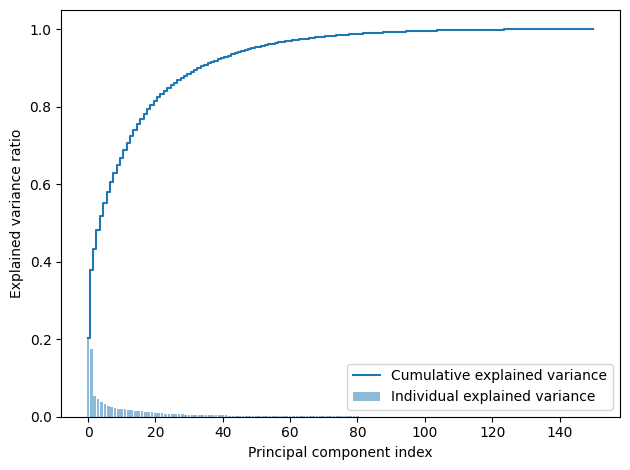

In [87]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [96]:
sum(pca.explained_variance_ratio_[:65])

0.9752856820332947

#  M1-M9

In [97]:
st = train_transaction.columns.get_loc('M1')
end = train_transaction.columns.get_loc('M9')

mdf = train_transaction.iloc[:, st:end+1]
mdf.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
#missing values percentage
m_cnt = 0
drop_cols = []
for col, cnt in mdf.isnull().sum().items():
    if(cnt > 0):
        per = round(cnt*100/ddf.shape[0], 2)
        if(per > 20):
            drop_cols.append(str(col))
        print(str(col) + ': ' + str(per))
        m_cnt = m_cnt + 1

M1: 45.91
M2: 45.91
M3: 45.91
M4: 47.66
M5: 59.35
M6: 28.68
M7: 58.64
M8: 58.63
M9: 58.63
